In [28]:
import cv2
import mediapipe as mp
mp_drawing = mp.solutions.drawing_utils
mp_objectron = mp.solutions.objectron
import logging
import matplotlib.pyplot as plt
plt.gray()
from IPython import display
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tqdm.autonotebook import tqdm


<Figure size 432x288 with 0 Axes>

In [23]:
# Constants
TRAIN_BUF=60000
BATCH_SIZE=512
TEST_BUF=10000
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [25]:
# Datasets
# load dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.fashion_mnist.load_data()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

4431872/4422102 [==============================] - 9s 2us/step


In [11]:
# For static images:
IMAGE_FILES = ['book.png', 'chair.png']
with mp_objectron.Objectron(static_image_mode=True,
                            max_num_objects=1,
                            min_detection_confidence=0.5,
                            model_name='Chair') as objectron:
  for idx, file in enumerate(IMAGE_FILES):
    image = cv2.imread(file)
    # Convert the BGR image to RGB and process it with MediaPipe Objectron.
    if not image:
        logging.error(str(file) + ' not found')
        continue
    results = objectron.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Draw box landmarks.
    if not results.detected_objects:
      print(f'No box landmarks detected on {file}')
      continue
    print(f'Box landmarks of {file}:')
    annotated_image = image.copy()
    for detected_object in results.detected_objects:
      mp_drawing.draw_landmarks(
          annotated_image, detected_object.landmarks_2d, mp_objectron.BOX_CONNECTIONS)
      mp_drawing.draw_axis(annotated_image, detected_object.rotation,
                           detected_object.translation)
      cv2.imwrite('/tmp/annotated_image' + str(idx) + '.png', annotated_image)

ERROR:root:book.png not found
ERROR:root:chair.png not found


In [12]:
#Generated images BGR or RGB?

In [13]:
class GAN(tf.keras.Model):
    """ a basic GAN class 
    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(GAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        # generating noise from a uniform distribution
        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)
        ### losses
        # losses of real with label "1"
        disc_real_loss = gan_loss(logits=logits_x, is_real=True)
        # losses of fake with label "0"
        disc_fake_loss = gan_loss(logits=logits_x_gen, is_real=False)
        disc_loss = disc_fake_loss + disc_real_loss

        # losses of fake with label "1"
        gen_loss = gan_loss(logits=logits_x_gen, is_real=True)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)
        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )
    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)
        
        
def gan_loss(logits, is_real=True):
    """Computes standard gan loss between logits and labels
    """
    if is_real:
        labels = tf.ones_like(logits)
    else:
        labels = tf.zeros_like(logits)

    return tf.compat.v1.losses.sigmoid_cross_entropy(
        multi_class_labels=labels, logits=logits
    )

In [14]:
N_Z = 64
# resembles a decoder architecture
generator = [
    tf.keras.layers.Dense(units=7 * 7 * 64, activation="relu"),
    tf.keras.layers.Reshape(target_shape=(7, 7, 64)),
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=3, strides=(2, 2), padding="SAME", activation="relu"
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=1, kernel_size=3, strides=(1, 1), padding="SAME", activation="sigmoid"
    ),
]

In [16]:
# discriminator resembles an encoder architecture
discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=3, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation=None),
]

In [17]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.RMSprop(0.005)# train the model
# model
model = GAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z
)

In [18]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [19]:
def plot_reconstruct(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

Epoch: 49 | disc_loss: 0.7908204197883606 | gen_loss: 1.3829904794692993


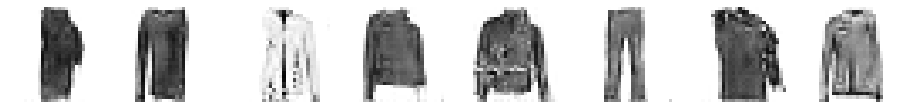

In [29]:
n_epochs = 50
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
    )
    plot_reconstruct(model)